In [45]:
import warnings

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

(array([1010.,  988., 1012., 1028., 1008.,  977.,  964., 1000., 1015.,
         998.]),
 array([0.01000565, 0.04400081, 0.07799596, 0.11199112, 0.14598628,
        0.17998143, 0.21397659, 0.24797175, 0.28196691, 0.31596206,
        0.34995722]),
 <BarContainer object of 10 artists>)

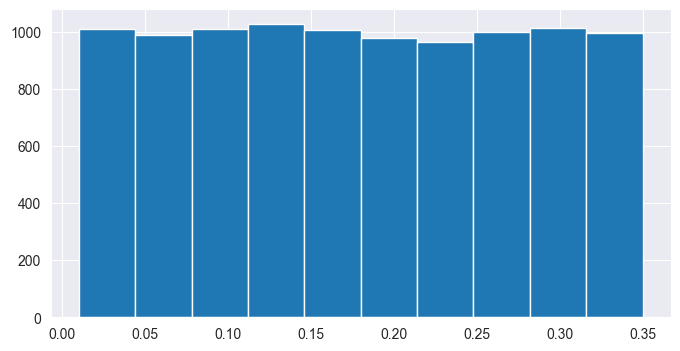

In [46]:
from hyperopt import hp, pyll

uniform_vals = [pyll.stochastic.sample(hp.uniform('max_ctr_complexity', 0.01, 0.35))
                for _ in range(10_000)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals)

In [47]:
def evaluate_model(X_train, X_val, y_train, y_val):
    model = XGBClassifier( random_state=42, enable_categorical=True, scale_pos_weight=2)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)

    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    return f1


def handle_nan(X_train, X_val):
    cat_cols = X_train.select_dtypes(exclude=['number']).columns.to_list()
    num_cols = X_train.select_dtypes(include='number').columns

    # Impute numerical columns
    imputer = IterativeImputer(initial_strategy='most_frequent', max_iter=5, n_nearest_features=4)
    X_train_num = pd.DataFrame(imputer.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
    X_val_num = pd.DataFrame(imputer.transform(X_val[num_cols]), columns=num_cols, index=X_val.index)

    # Handle categorical columns
    for column in cat_cols:
        # Add 'Missing' category
        X_train[column] = X_train[column].cat.add_categories('Missing')
        X_val[column] = X_val[column].cat.add_categories('Missing')

        # Fill NaN values with 'Missing'
        X_train[column] = X_train[column].fillna('Missing')
        X_val[column] = X_val[column].fillna('Missing')

    # Concatenate numerical and categorical dataframes
    X_train_processed = pd.concat([X_train_num, X_train[cat_cols]], axis=1)
    X_val_processed = pd.concat([X_val_num, X_val[cat_cols]], axis=1)

    return X_train_processed, X_val_processed

In [48]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union


def evaluate_model_opt(X_train, X_val, y_train, y_val, space):
    model = XGBClassifier(**space, random_state=42, enable_categorical=True, scale_pos_weight=2)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)

    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    y_pred = model.predict(X_val)

    return f1_score(y_val, y_pred), model


def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                          X_train: pd.DataFrame, y_train: pd.Series,
                          X_val: pd.DataFrame, y_val: pd.Series) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value is 50.
    metric : callable
        Metric to maximize. Default is accuracy
        Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """

    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k, val in space.items()}
    space = {k: (int(val) if k in int_vals else val) for k, val in space.items()}
    score, model = evaluate_model_opt(X_train, X_val, y_train, y_val, space)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}


In [49]:
from typing import Any, Dict, Sequence


def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a Trial object (sequence of trial dictionaries)
    to a Pandas DataFrame.
    Parameters
    ----------
    trial : List[Dict[str, Any]]
    A list of trial dictionaries.
    Returns
    -------
    pd.DataFrame
    A DataFrame with columns for the loss, trial id, and
    values from each trial dictionary.
    """
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k: (v[0] if isinstance(v, list) else v)
               for k, v in misc['vals'].items()
               }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)

In [50]:
def jitter(df: pd.DataFrame, col: str, amount: float = 1) -> pd.Series:
    """
        Add random noise to the values in a Pandas DataFrame column.
        This function adds random noise to the values in a specified
        column of a Pandas DataFrame. The noise is uniform random
        noise with a range of `amount` centered around zero. The
        function returns a Pandas Series with the jittered values.
        Parameters
        ----------
        df : pd.DataFrame
        The input DataFrame.
        col : str
        The name of the column to jitter.
        amount : float, optional
        The range of the noise to add. The default value is 1.
        Returns
        -------
        pd.Series
        A Pandas Series with the jittered values.
    """
    vals = np.random.uniform(low=-amount / 2, high=amount / 2,
                             size=df.shape[0])
    return df[col] + vals
    fig, ax = plt.subplots(figsize=(8, 4))
    (hyper2hr
     .assign(max_depth=lambda df: jitter(df, 'depth', amount=.8))
     .plot.scatter(x='max_depth', y='loss', alpha=.1, color='purple', ax=ax)
     )



In [51]:
# X = pd.read_csv('../data/new_features/df_.csv')
# y = pd.read_csv('../data/new_features/y.csv')

X = pd.read_csv('../data/feature_selection/df.csv')
y = pd.read_csv('../data/feature_selection/y.csv')

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2432 entries, 1324 to 99
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avg_away_rating_attack        2432 non-null   float64
 1   avg_away_rating_defence       2432 non-null   float64
 2   avg_home_rating_attack        2432 non-null   float64
 3   avg_home_team_rating          2432 non-null   float64
 4   defensive_weakness_away       2421 non-null   float64
 5   defensive_weakness_home       2420 non-null   float64
 6   ewm_home_team_goals_conceded  2420 non-null   float64
 7   ewm_possession_away           2421 non-null   float64
 8   ewm_shoton_away               2421 non-null   float64
 9   ewm_shoton_home               2420 non-null   float64
 10  home_streak_wins              2432 non-null   float64
 11  player_rating_away_player_10  2432 non-null   int64  
 12  player_rating_away_player_8   2432 non-null   int64  
 13  player_

In [54]:
evaluate_model(X_train, X_val, y_train, y_val)

0.6657183499288762

In [56]:
# options = {
#     'depth': hp.quniform('depth', 8, 15, 1),
#     'bagging_temperature': hp.loguniform('bagging_temperature', np.log(0.75), np.log(0.95)),
#     'rsm': hp.loguniform('rsm', np.log(0.75), np.log(0.95)),
#     'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
#     'iterations': 50,
#     # 'max_ctr_complexity': hp.randint('max_ctr_complexity', 0, 8),
#     'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
# }

options = {'max_depth': hp.quniform('max_depth', 3, 13, 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
           'subsample': hp.uniform('subsample', 0.75, 1),  # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.75, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 10),
           'reg_lambda': hp.uniform('reg_lambda', 1, 10),
           'gamma': hp.loguniform('gamma', -10, 10),  # regularization
           'learning_rate': hp.uniform('learning_rate', 0.01, 0.35),  # boosting
           }

trials = Trials()

tuned_params = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_val, y_val),
                    space=options,
                    algo=tpe.suggest,
                    max_evals=400,
                    trials=trials)

print("Best Hyperparameters:", tuned_params)

100%|██████████| 400/400 [00:50<00:00,  7.97trial/s, best loss: -0.6734992679355783]
Best Hyperparameters: {'colsample_bytree': 0.865909073365077, 'gamma': 0.02957821399273854, 'learning_rate': 0.29887642861553626, 'max_depth': 13.0, 'min_child_weight': 3.0962631150235733, 'reg_alpha': 7.4894842428955135, 'reg_lambda': 1.984679484144173, 'subsample': 0.8645649743982323}


In [57]:
hyper2hr = trial2df(trials)

In [58]:
hyper2hr

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,loss,tid
0,0.901767,0.000076,0.210113,6.0,10.592636,3.080074,8.375216,0.989275,-0.659187,0
1,0.999592,483.644292,0.234645,11.0,8.517806,0.769396,1.507204,0.814368,-0.627540,1
2,0.790054,0.009008,0.206156,3.0,8.464785,9.065311,8.960507,0.822405,-0.647315,2
3,0.879673,0.000175,0.347385,6.0,0.529697,2.119549,3.605741,0.817378,-0.647328,3
4,0.990940,0.121326,0.229022,10.0,1.229247,4.755240,4.736952,0.931453,-0.658156,4
...,...,...,...,...,...,...,...,...,...,...
395,0.759991,3.731670,0.288792,12.0,1.479849,6.407772,3.903889,0.765695,-0.659218,395
396,0.876310,11.367940,0.100661,5.0,4.498889,7.886897,9.289662,0.832390,-0.660300,396
397,0.850323,38.005659,0.156763,8.0,2.682646,2.366533,1.303979,0.785766,-0.662269,397
398,0.824134,2.068269,0.028843,3.0,2.059995,2.946240,1.843754,0.768485,-0.661157,398


<Axes: >

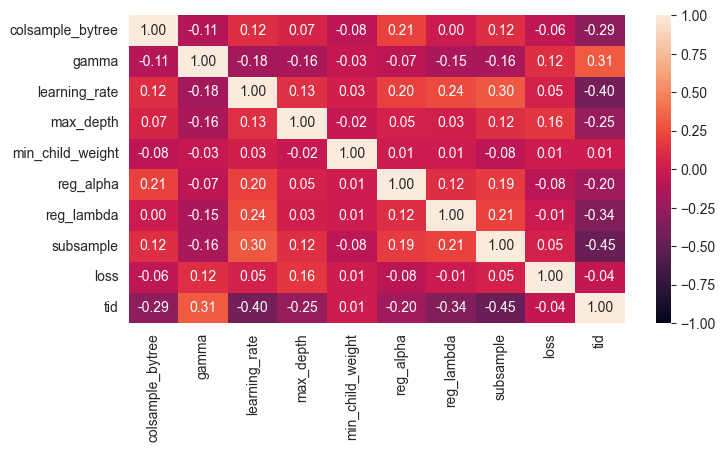

In [59]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(hyper2hr.corr(method='spearman'),
            annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax)

<Axes: xlabel='learning_rate', ylabel='loss'>

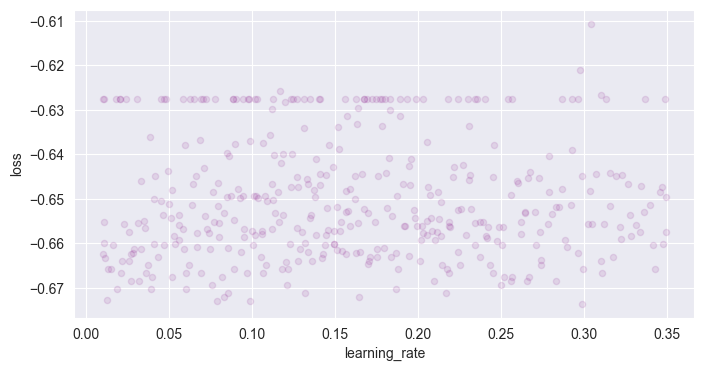

In [60]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
 .plot.scatter(x='learning_rate', y='loss', alpha=.1, color='purple', ax=ax)
 )

<Axes: xlabel='max_depth', ylabel='loss'>

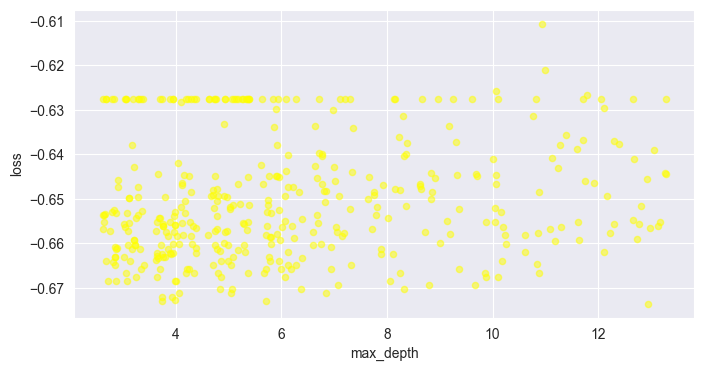

In [61]:
# This makes it quite clear that the algorithm spent a good amount of time at depth 10.
# If we want to get even fancier, we can color this by trial attempt. The later attempts are
# represented by the yellow color.
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
 .assign(max_depth=lambda df: jitter(df, 'max_depth', amount=.8))
 .plot.scatter(x='max_depth', y='loss', alpha=.5,
               color='yellow', cmap='viridis', ax=ax)
 )

In [62]:
int_vals = ['max_depth', 'reg_alpha']
tuned_params = {k: (int(val) if k in int_vals else val)
         for k, val in tuned_params.items()}

f1, xgb_tune = evaluate_model_opt(X_train, X_val, y_train, y_val, tuned_params)
print(f'result: {f1}')

result: 0.6734992679355783


In [63]:
xgb = XGBClassifier(random_state=42, enable_categorical=True)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)

y_pred = xgb.predict(X_val)
f1 = f1_score(y_val, y_pred)

In [64]:
from sklearn import metrics

print(metrics.classification_report(y_val, y_pred=xgb_tune.predict(X_val), target_names=['Home Win', 'Home not win']))

              precision    recall  f1-score   support

    Home Win       0.76      0.47      0.58       330
Home not win       0.57      0.83      0.67       278

    accuracy                           0.63       608
   macro avg       0.67      0.65      0.63       608
weighted avg       0.67      0.63      0.62       608


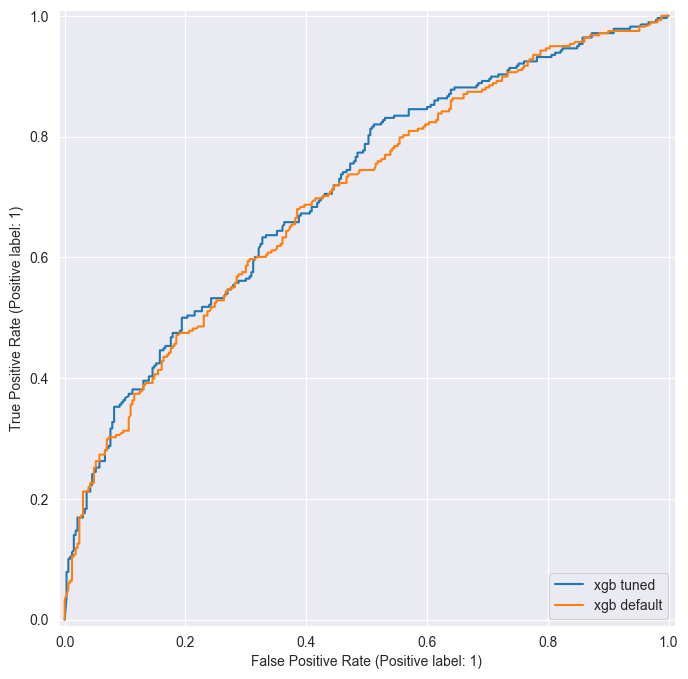

In [65]:
fig, ax = plt.subplots(figsize=(8, 8))
metrics.RocCurveDisplay.from_estimator(xgb_tune, X_val, y_val, ax=ax, label='xgb tuned')

metrics.RocCurveDisplay.from_estimator(xgb, X_val, y_val, ax=ax, label='xgb default')